# Mareadita con Python 
## Predicciones y resultados de Partidos

Esta charla es una pequeña muestra de algunas herramientas que se pueden encontrar principalmente en la librería sci-kit learn, aplicadas a un set de datos con el objetivo de aproximarnos a la predicción de resultados de partidos de la liga Europea.

Set de datos utilizado: https://www.kaggle.com/hugomathien/soccer

Pasos Básicos con los datos:
* Carga.
* Limpieza y Transformación.
* Reducción de Dimensionalidad.
    * Filtro de Variancia
    * PCA
* Aprendizaje Supervisado
    * Validación cruzada
    * Selección de Parámetros

Extra: 
* Pipelines y GridSearch: Reduciendo la cantidad de código necesario para el proceso completo

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import itertools
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib as jl
from IPython.display import display

# Utiles

In [2]:
# pd.options.display.max_rows = 1000   # cuantas rows mostrar al imprimir un dataframe de pandas

def ganador(x):
    if x["goles_l"] > x["goles_v"]:
        return 1
    return 0

def perdedor(x):
    if x["goles_l"] < x["goles_v"]:
        return 1
    return 0

def empate(x):
    if x["goles_l"] > x["goles_v"]:
        return 1
    return 0

def resultado(x):
    if x["goles_l"] < x["goles_v"]:
        return 1
    if x["goles_l"] > x["goles_v"]:
        return 2
    return 0

def f_importances(est):
    """ 
    Esta función plotea un grafico de barras con la importancia de
    cada feature utilizada por el estimador dado por parametro
    """
    fig, ax = plt.subplots()
    x_ind = est.feature_importances_
    plt.bar(range(len(x_ind)), est.feature_importances_)
    ax.set_xlabel("Features")
    ax.set_ylabel("Porcentaje")
    plt.show()

def plot_confusion_matrix(cm, classes=["D-W", "Lose"], title='Confusion matrix', norm=True):
    """
    Esta función imprime una matriz de confución. El parámetro 'norm' determina si los valores deben
    mostrarse como recuento total de las ocurrencias, o como medida porcentual donde 1 es el total
    """
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if norm:
        cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 3)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()

# Carga de Datos

In [ ]:
# En caso de ya haber realizado la lectura de la BD, y guardado en un csv los datos preprocesados, ejecutar esta celda
# y seguir directamente desde la sección "Obteniendo las Clases"
ruta = "path al archivo csv"
data_encuentros = pd.read_csv(ruta)

In [3]:
ruta = "ruta al archivo sqlite"                             # Path al archivo sqlite
conection = sqlite3.connect(ruta)                       # Conección a la base de datos a utilizar
equipos = pd.read_sql("select * from Team", conection)  # Consulta para cargar la tabla de equipos

equipos.drop(axis=1, labels=["team_fifa_api_id", "team_short_name", "id"], inplace=True)  # Eliminando columnas innecesarias

equipos.fillna(-1, inplace=True)                        # Rellanar los valores nulos con '-1'
print("Equipos")
display(equipos[5:7])

pd.options.display.max_columns = 25                     # Seteando cuantas columnas mostrar al imprimir un dataframe

e_stats = pd.read_sql("select * from Team_Attributes", conection)
e_stats["date"] = pd.DatetimeIndex(e_stats["date"]).year  # Para este ejemplo, solo nos interesa el año, por lo que
                                                          # eliminamos el resto de la fecha
e_stats.drop(axis=1, labels=["id"], inplace=True)
e_stats.fillna(-1, inplace=True)
print("Estadisticas de los Equipos")
display(e_stats[5:7])

partidos = pd.read_sql("select * from Match", conection)
partidos["date"] = pd.DatetimeIndex(partidos["date"]).year
partidos.drop(axis=1, labels=["id"], inplace=True)
partidos.fillna(-1, inplace=True)
print("Partidos")
display(partidos[8:10])

Equipos


,team_api_id,team_long_name
5,8635,RSC Anderlecht
6,9991,KAA Gent


Estadisticas de los Equipos


,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
5,77,8485,2012,58,Balanced,-1.0,Little,62,Mixed,Organised,45,Normal,70,Lots,55,Normal,Organised,40,Medium,40,Press,60,Normal,Cover
6,77,8485,2013,62,Balanced,-1.0,Little,45,Mixed,Organised,40,Normal,50,Normal,55,Normal,Organised,42,Medium,42,Press,60,Normal,Cover


Partidos


,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,...,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
8,1,1,2008/2009,1,2008,492481,10001,9986,1,0,-1.0,-1.0,...,2.20,3.3,3.1,2.25,3.25,2.8,2.20,3.3,2.8,2.25,3.2,2.8
9,1,1,2008/2009,10,2008,492564,8342,8571,4,1,-1.0,-1.0,...,1.27,5.0,10.0,1.30,4.35,8.5,1.25,5.0,10.0,1.29,4.5,9.0


#### Dado que se puede establecer una prescedencia entre los valores originales, hago manualmente los reemplazos para colocar esta prescedencia y que a futuro se puedan probar variantes intermedias

In [4]:
replaces = {"buildUpPlaySpeedClass":{"Slow":0, "Balanced":1, "Fast":2},
            "buildUpPlayDribblingClass":{"Little":0, "Normal":1, "Lots":2},
            "buildUpPlayPassingClass": {"Short":0, "Mixed":1, "Long":2},
            "buildUpPlayPositioningClass": {"Free Form":0, "Organised":1},
            "chanceCreationPassingClass": {"Safe":0, "Normal":1, "Risky":2},
            "chanceCreationCrossingClass": {"Little":0, "Normal":1, "Lots":2},
            "chanceCreationShootingClass": {"Little":0, "Normal":1, "Lots":2},
            "chanceCreationPositioningClass": {"Free Form":0, "Organised":1},
            "defencePressureClass": {"Deep":0, "Medium":1, "High":"2"},
            "defenceAggressionClass": {"Contain":0, "Double":1, "Press": 2},
            "defenceTeamWidthClass": {"Narrow":0, "Normal":1, "Wide":2},
            "defenceDefenderLineClass": {"Cover":0, "Offside Trap": 1}
           }
c_stats = e_stats.replace(replaces)
c_stats[2:4]
# pd.factirize

,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
2,434,9930,2015,47,1,41.0,1,54,1,1,54,1,63,1,64,1,1,47,1,44,2,54,1,0
3,77,8485,2010,70,2,-1.0,0,70,2,1,70,2,70,2,70,2,1,60,1,70,1,70,2,0


#### En caso de que el orden no importe, se puede hacer rápido y limpio de la siguiente manera

In [5]:
# Factorize solo se puede aplicar columna por columna, y no se puede predefinir el orden.

factorized_stats = pd.DataFrame()
for c in e_stats.columns:
    factorized_stats[c] = e_stats[c].factorize()[0]   # 'factorize' devuelve una tupla cuyo primer elemento es el arreglo
                                                      # transformado, y el segundo, las keys encontradas

factorized_stats[:2]

,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,1,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0


In [6]:
# Dejando solo las columnas de interes
encuentros = partidos[["date", "home_team_api_id", "away_team_api_id","home_team_goal","away_team_goal"]]
index = ["fecha", "id_local", "id_visitante", "goles_l", "goles_v"]       # Reindexando por nombres más amigables
encuentros.columns= index
encuentros[:2]

,fecha,id_local,id_visitante,goles_l,goles_v
0,2008,9987,9993,1,1
1,2008,10000,9994,0,0


### Combinando los datos que si nos interesan

In [7]:
# Pandas permite hacer uniones al estilo SQL. En este caso, ambas operaciones equivalen a dos Joins (left-outer Join)
data_encuentros = pd.merge(encuentros, equipos, left_on="id_local", right_on="team_api_id", how="left")
data_encuentros = pd.merge(data_encuentros, equipos, left_on="id_visitante", right_on="team_api_id", how="left")
data_encuentros[10:12]

,fecha,id_local,id_visitante,goles_l,goles_v,team_api_id_x,team_long_name_x,team_api_id_y,team_long_name_y
10,2008,9985,9986,1,2,9985,Standard de Liège,9986,Sporting Charleroi
11,2008,10000,9991,0,2,10000,SV Zulte-Waregem,9991,KAA Gent


In [8]:
# Idem anterior, pero esta vez con los stats de cada equipo.
data_encuentros = pd.merge(data_encuentros, c_stats, left_on=["fecha", "id_local"], right_on=["date", "team_api_id"], how="left")
data_encuentros = pd.merge(data_encuentros, c_stats, left_on=["fecha", "id_visitante"], right_on=["date", "team_api_id"], suffixes=('', '_vis'), how="left")
data_encuentros.fillna(-1, inplace=True)
data_encuentros[10:12]

,fecha,id_local,id_visitante,goles_l,goles_v,team_api_id_x,team_long_name_x,team_api_id_y,team_long_name_y,team_fifa_api_id,team_api_id,date,...,chanceCreationCrossing_vis,chanceCreationCrossingClass_vis,chanceCreationShooting_vis,chanceCreationShootingClass_vis,chanceCreationPositioningClass_vis,defencePressure_vis,defencePressureClass_vis,defenceAggression_vis,defenceAggressionClass_vis,defenceTeamWidth_vis,defenceTeamWidthClass_vis,defenceDefenderLineClass_vis
10,2008,9985,9986,1,2,9985,Standard de Liège,9986,Sporting Charleroi,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0
11,2008,10000,9991,0,2,10000,SV Zulte-Waregem,9991,KAA Gent,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0


In [9]:
# Revisando el tamaño final de nuestro conjunto
data_encuentros.shape

(25979, 57)

In [10]:
# Guardando el nuevo dataset para no tener que realizar la misma tarea cada vez
data_encuentros.to_csv("data_encuentros.csv")

# Obteniendo las Clases

In [11]:
# obteniendo columnas de resultados para el entrenamiento

win = data_encuentros.apply(lambda x: ganador (x), axis=1)
defeat = data_encuentros.apply(lambda x: perdedor (x), axis=1)
match_result = data_encuentros.apply(lambda x: resultado (x), axis=1)

# Eliminando datos sin utilidad

In [12]:
pd.options.display.max_columns = 100
data_encuentros[:2]

,fecha,id_local,id_visitante,goles_l,goles_v,team_api_id_x,team_long_name_x,team_api_id_y,team_long_name_y,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,team_fifa_api_id_vis,team_api_id_vis,date_vis,buildUpPlaySpeed_vis,buildUpPlaySpeedClass_vis,buildUpPlayDribbling_vis,buildUpPlayDribblingClass_vis,buildUpPlayPassing_vis,buildUpPlayPassingClass_vis,buildUpPlayPositioningClass_vis,chanceCreationPassing_vis,chanceCreationPassingClass_vis,chanceCreationCrossing_vis,chanceCreationCrossingClass_vis,chanceCreationShooting_vis,chanceCreationShootingClass_vis,chanceCreationPositioningClass_vis,defencePressure_vis,defencePressureClass_vis,defenceAggression_vis,defenceAggressionClass_vis,defenceTeamWidth_vis,defenceTeamWidthClass_vis,defenceDefenderLineClass_vis
0,2008,9987,9993,1,1,9987,KRC Genk,9993,Beerschot AC,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0
1,2008,10000,9994,0,0,10000,SV Zulte-Waregem,9994,Sporting Lokeren,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0


In [13]:
lastre = ["team_api_id_x", "team_api_id_y",
          "team_long_name_x", "team_long_name_y",
          "team_fifa_api_id", "team_fifa_api_id_vis",
          "team_api_id", "team_api_id_y", "team_api_id_vis",
          "date", "date_vis",
          "fecha",
          "id_local", "id_visitante",
          "goles_l", "goles_v"
        ]


for c in data_encuentros.columns:
    if "Class" not in c:
        lastre.append(c)

data = data_encuentros.drop(lastre, axis=1)

# Escalando los datos a un mismo rango de valores, ya que algunos
# clasificadores dan más importancia a features con rangos de valores 
# más elevados aunque tengan igual variabilidad que otros con rangos
# más acotados (Ej:algunas Redes Neuronales)
scaler = preprocessing.MinMaxScaler((-1,1))
data = pd.DataFrame(scaler.fit_transform(data))

data.shape

(25979, 24)

In [14]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
count,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000,25979.000000
mean,-0.007326,-0.356249,-0.050336,0.400400,0.006865,0.023031,0.023057,0.355864,-0.062525,0.357455,-0.016308,-0.223835,-0.008250,-0.356429,-0.050079,0.400208,0.006865,0.022954,0.023108,0.356442,-0.062704,0.356942,-0.016642,-0.223796
std,0.663420,0.491261,0.628418,0.889694,0.659546,0.672871,0.671674,0.883573,0.615845,0.888204,0.636191,0.526801,0.662764,0.491375,0.628548,0.889759,0.659883,0.672873,0.671825,0.883754,0.616021,0.888218,0.636236,0.527000
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.333333,-0.333333,0.333333,1.000000,0.333333,0.333333,0.333333,1.000000,0.333333,1.000000,0.333333,0.000000,0.333333,-0.333333,0.333333,1.000000,0.333333,0.333333,0.333333,1.000000,0.333333,1.000000,0.333333,0.000000
75%,0.333333,-0.333333,0.333333,1.000000,0.333333,0.333333,0.333333,1.000000,0.333333,1.000000,0.333333,0.000000,0.333333,-0.333333,0.333333,1.000000,0.333333,0.333333,0.333333,1.000000,0.333333,1.000000,0.333333,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Reducción de Dimensinalidad
Reducir la cantidad de features disminuye la complejidad del problema, y proporciona un buen ahorro de tiempo de entrenamiento, pero es necesario saber que features eliminar. Una de las herramientas utilizadas para esto es PCA o alguna de sus variantes como RandomizedPCA, KernelPCA, etc (RandomizedPCA ya esta deprecado y se realiza como PCA(svd_solver="randomized").

Otras opciones pueden son:
* VarianceThreshold (Demasiado básico, solo elimina las features que presentan una variación por debajo del límite establecido, por ejemplo que el 80% de los datos presenten el mismo valor)
* Random Projection
* Feature agglomeration

In [15]:
pca_d = PCA(n_components=5)         # Análisis de Componentes Principales: analiza los datos y devuelve las
                                    # n_components que más explicam la variación el df completo
t_data = pca_d.fit_transform(data)
print("Variance ratio total: {}".format(np.sum(pca_d.explained_variance_ratio_)))

Variance ratio total: 0.9319896442297833


### Sets para predecir derrotas

In [16]:
s_data, s_defeat = shuffle(t_data, defeat)          # Mezclando los datos

# particionando en conjuntos de entrenamiento y testeo
x_dtrain, x_dtest, y_dtrain, y_dtest = train_test_split(s_data, s_defeat, test_size=.25)
np.unique(y_dtest, return_counts=True)              # haciendo un recuento de cada clase en el set de entrenamiento

(array([0, 1]), array([4625, 1870]))

### Sets para predecir victorias

In [17]:
s_data, s_win = shuffle(t_data, win)
x_wtrain, x_wtest, y_wtrain, y_wtest = train_test_split(s_data, s_win, test_size=.25)
np.unique(y_wtest, return_counts=True)

(array([0, 1]), array([3515, 2980]))

### Set con resultados completos

In [18]:
x_train, x_test, y_train, y_test = train_test_split(t_data, match_result, test_size=.25)
# x_train.shape, x_test.shape, y_train.shape, y_test.shape
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([4899, 5587, 8998]))

# Tratando de predecir Derrotas
Para empezar, un punto de comparación: Dummy Classifier

### Dummy

score: 0.5903002309468822


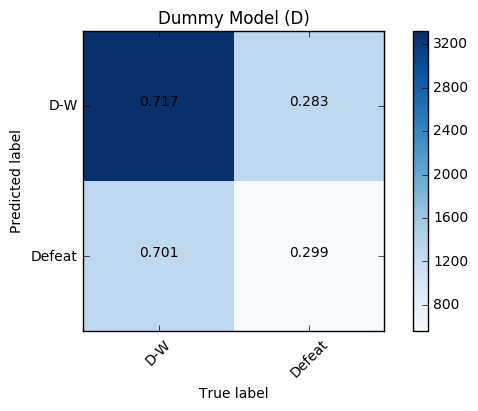

In [19]:
d_clf = DummyClassifier()                       # un Clasificador "tonto", que solo clasifica por mayoria
d_clf.fit(x_dtrain, y_dtrain)                   # entrenamiento con el conjunto de prueba
d_result = d_clf.predict(x_dtest)
d_ma = confusion_matrix(d_result, y_dtest)      # calculando la matriz de confusión

print("score: {}".format(d_clf.score(x_dtest, y_dtest)))
plot_confusion_matrix(d_ma, title="Dummy Model (D)", classes=["D-W","Defeat"], norm=True)

## Gaussian Naive Bayes (Sin Parametros)

score: 0.7071593533487298


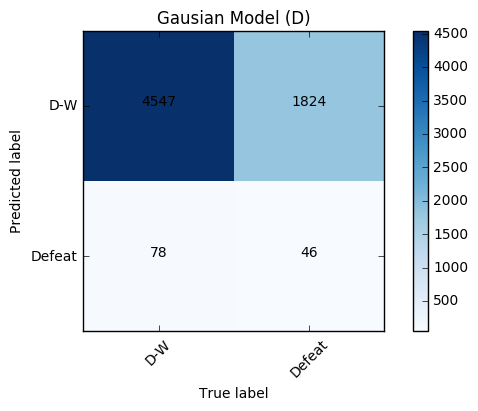

In [20]:
g_clf = GaussianNB()    # Clasificador Bayesiano "Ingenuo", asume que las features no estan relacionadas, y que cada
                        # una brinda una probabilidad de pertenencia a un u otro grupo sin importar el valor de las demás
g_clf.fit(x_dtrain, y_dtrain)
g_dresult = g_clf.predict(x_dtest)

g_dma = confusion_matrix(g_dresult, y_dtest)

print("score: {}".format(g_clf.score(x_dtest, y_dtest)))
plot_confusion_matrix(g_dma, title="Gausian Model (D)", classes=["D-W","Defeat"], norm=False)

## Primer Problema
* Puede dar un buen score para la partición exacta que se utiliza para entrenar, y fallar si se utiliza otra o se lo somete a datos que nunca antes habia visto.

Como solventarlo?
* Mantener siempre  3 particiones: 
    * una particion de entrenamiento.
    * una partición de prueba.
    * una partición de validación oculta.

para no reducir tanto el tamaño del df, se puede utilizar técnicas como Cross Validation, donde se divide solo en conjunto de entrenamiento y de validación (como en este caso) y el conjunto de entrenamiento se divide en varias particiones para utilizar una de ellas como prueba, y luego se las va mezclando para volver a tener un nuevo set de entrenamiento y de testeo

### Cross Validation

In [21]:
# cross_val_score(  Estimador, Datos_entrenamiento, resultados_esperados,
#                    cv=cant_particiones_a_obtener, n_jobs=cant_procesos)
scores = cross_val_score(GaussianNB(), x_dtrain, y_dtrain, cv=5, n_jobs=4)
for i, s in enumerate(scores):
    print("Score Fold {}: {}%".format(i, np.around(s*100, 2)))
print("Accuracy: {} (+/- {})".format(np.around(scores.mean(), 3), scores.std() * 2))

Score Fold 0: 71.16%
Score Fold 1: 71.03%
Score Fold 2: 70.62%
Score Fold 3: 69.92%
Score Fold 4: 71.25%
Accuracy: 0.708 (+/- 0.009803403425857298)


In [23]:
# Verificando cuantos elementos de cada clase hay en el set de validación
dw, d = np.unique(y_dtest, return_counts=True)
print("D-W: {}\nDefeat: {}".format(d[0], d[1]))

D-W: 4625
Defeat: 1870


### Resultado? Muy Mal Predictor...

# Con Parámetros
## ExtraTrees
Probando con Arboles de Desición

In [24]:
forest = ExtraTreesClassifier(n_estimators=20,          # Nro de arboles
                              criterion="gini",         # Criterio para generar las particiones
                              max_features="log2",      # Cant de features que se toman para generar una partición
                              n_jobs=4,
                              random_state=100          # nro utilizado como semilla para la inicialización del arbol
                             )

scores = cross_val_score(forest, x_dtrain, y_dtrain, cv=5, n_jobs=4)    # Cross Validation aplicada al arbol de desición
for i, s in enumerate(scores):
    print("Score Fold {}: {}%".format(i, np.around(s*100, 2)))
print("Accuracy: {} (+/- {})".format(np.around(scores.mean(), 3), scores.std() * 2))

Score Fold 0: 69.09%
Score Fold 1: 68.98%
Score Fold 2: 69.03%
Score Fold 3: 70.28%
Score Fold 4: 69.71%
Accuracy: 0.694 (+/- 0.01012909961527723)


## Más Problemas
Como elegir los parámetros sin ejecutarlos separadamente ni hacer loops molestos? Principalemte, PRESTAR ATENCIÓN EN LAS CLASES DE ESTADÍSTICA! (para reconocer a que modelo se ajusta más el problema). Una vez identificado, se pueden utilizar otras herramientas para acelerar el proceso

In [25]:
# alguien "vivo" realiza una combinación de los valores probables elegidos para cada parámetro (como se muestra a
# continuación por ejemplo), pero debe arreglarselas para reconocer y mantener la mejor combinación
prop_1 = [1, 2]
prop_2 = ["a", "b"]
prop_3 = ["Carlos", "Juan"]

for p_1, p_2, p_3 in itertools.product(prop_1, prop_2, prop_3):
    print(p_1, p_2, p_3)

1 a Carlos
1 a Juan
1 b Carlos
1 b Juan
2 a Carlos
2 a Juan
2 b Carlos
2 b Juan


Alguien más vivo...
### Grid Search
Dado un diccionario de parámetros y valores, GridSearch (GS) realiza la combinación de los mismos, mantiene el score logrado con cada una, y da acceso directo a la mejor combinación y al mejor estimador obtenido (internamiente también realiza un avalidación cruzada).

NOTA: GS prueba todas las posibilidades, asi que el proceso puede ser lento. Se puede usar tambien RandomGridSearchCV el cual solo prueba un subconjunto de los valores, haciendo que sea mucho más rápido en terminar pero puede llegar a no detectar la mejor combinación de todas.

In [26]:
param_grid ={"n_estimators":[20, 40, 100],                    # Nro de arboles
             "n_jobs":[4],
             "warm_start":[True],                             # Reusar o no arboles existentes
             "criterion": ["gini", "entropy"],                # Criterio para generar las particiones
             "max_features": ["auto", "log2"],                # Cant de features que se toman para generar una partición
             "random_state": [0, 10, 20],
            }
gs_forest = GridSearchCV(ExtraTreesClassifier(), param_grid, cv=5, n_jobs=4)

gs_forest.fit(x_dtrain, y_dtrain)
gs_forest.best_params_, gs_forest.best_score_

({'criterion': 'gini',
  'max_features': 'auto',
  'n_estimators': 100,
  'n_jobs': 4,
  'random_state': 0,
  'warm_start': True},
 0.69492917265448573)

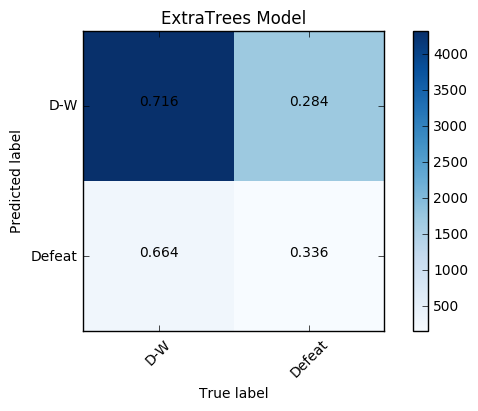

In [27]:
# Verificando resultados del mejor estimador obtenido con GridSearchCV
gsf_dresult = gs_forest.best_estimator_.predict(x_dtest)
gsf_dma = confusion_matrix(gsf_dresult, y_dtest)

plot_confusion_matrix(gsf_dma, title="ExtraTrees Model", classes=["D-W","Defeat"], norm=True)

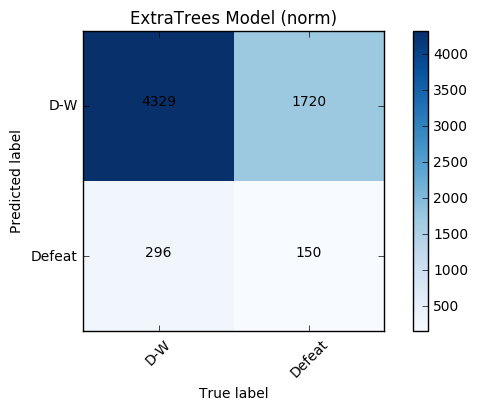

In [28]:
# Verificando la misma matriz, pero esta vez sin normalizar los datos
plot_confusion_matrix(gsf_dma, title="ExtraTrees Model (norm)", classes=["D-W","Defeat"], norm=False)

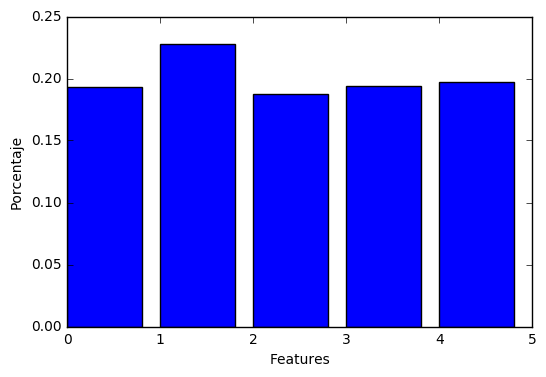

In [29]:
# Verificando la importancia de cada feature. Si alguna sea muy baja significa que casi no influye en la desición por lo
# que podría ser eliminada. En este caso, todas las features tomadas tienen practicamente la misma relevancia.
f_importances(gs_forest.best_estimator_)

## Lo mismo, pero para predecir Victorias...

(array([0, 1]), array([3515, 2980]))


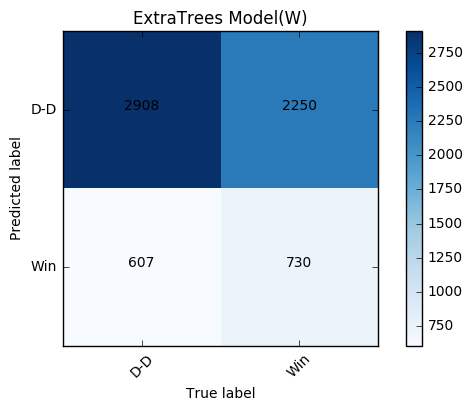

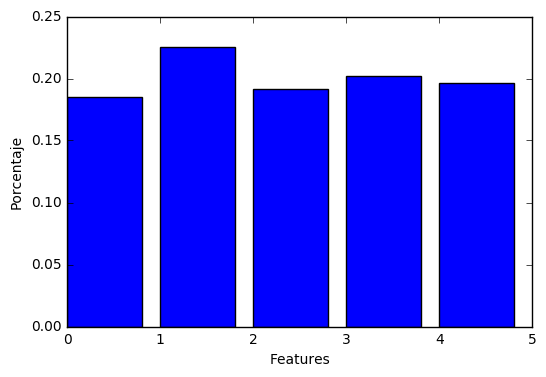

In [30]:
param_grid ={"n_estimators":[80, 100, 150],
             "n_jobs":[4],
             "warm_start":[True],
             "criterion": ["gini", "entropy"],
             "max_features": [None, "auto", "log2"],
             "random_state": [10, 20, 30]
            }

gs_wforest = GridSearchCV(ExtraTreesClassifier(), param_grid, cv=5, n_jobs=4)
gs_wforest.fit(x_wtrain, y_wtrain)

gsf_wresult = gs_wforest.best_estimator_.predict(x_wtest)
gsf_wma = confusion_matrix(gsf_wresult, y_wtest)
print(np.unique(y_wtest, return_counts=True))

plot_confusion_matrix(gsf_wma, title="ExtraTrees Model(W)", classes=["D-D", "Win"], norm=False)
f_importances(gs_wforest.best_estimator_)

## Todo Junto
(Victorias, empates y derrotas)

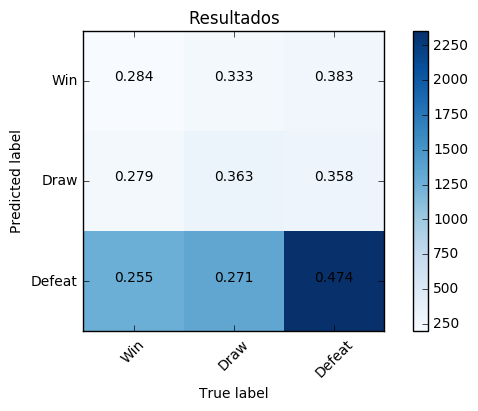

Win:	 1697 
Draw:	 1879 
Defeat:	 2919


In [31]:
params ={"n_estimators":[100, 150, 200],                      # Nro de arboles
             "n_jobs":[4],
             "warm_start":[True],                             # Reusar o no arboles existentes
             "criterion": ["gini", "entropy"],                # Criterio para generar las particiones
             "max_features": ["auto"],                        # Cant de features que se toman para generar una partición
             "random_state": [10,20,30]
            }

final_forest = GridSearchCV(ExtraTreesClassifier(), params, cv=4, n_jobs=4)
final_forest.fit(x_train, y_train)

result = final_forest.best_estimator_.predict(x_test)
ma = confusion_matrix(result, y_test)

plot_confusion_matrix(ma, classes=["Win", "Draw", "Defeat"], norm=True, title="Resultados")

clases, contador = np.unique(y_test, return_counts=True)
print("Win:\t {} \nDraw:\t {} \nDefeat:\t {}".format(contador[0], contador[1], contador[2]))

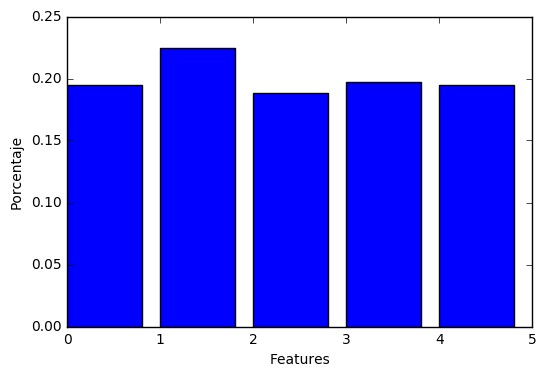

In [32]:
f_importances(final_forest.best_estimator_)

# Resultados finales?
## Perdimos por goleada... (pero no somos los únicos...)

Trabajos relacionados:
* Predicción de resultados de partidos de la Liga Europea: https://www.kaggle.com/airback/d/hugomathien/soccer/match-outcome-prediction-in-football/comments
* Predicción de partidos del mundial de Futbol: https://github.com/fisadev/world_cup_learning


## Un Plus: Pipelines!
En caso de estar familiarizado con los métodos anteriores, es posible reducir mucho la cantidad de código necesario para implementar dichas soluciones utilizando una "linea de ensamblaje" o Pipeline.

Para utilizarlo, solo se necesita que el último elemento de la cadena implemente la función "predict", y todos los anteriores implementen "fit" y "transform", de modo que la entrada pueda ir siendo procesada y transformada hasta llegar al elemento final que estará encargado de predecir el resultado final derivado de los datos.
En el Pipe, cada elemento es una tupla (Nombre, Elemento), donde el nombre se utiliza para setear los parámetros del Elemento ( Nombre__propiedad=valor, es decir nombre seguido de doble guion bajo seguido de la propiedad a setear )

In [33]:
pca_pipe = PCA()
vt_pipe = VarianceThreshold()
tree_pipe = ExtraTreesClassifier()

pipe_1 = Pipeline([("pca", pca_pipe),
                   ("vt", vt_pipe),
                   ("tree", tree_pipe)])

pipe_1.set_params(pca__n_components=5,          # Equivalente a haber hecho pca_pipe = PCA(n_components=5)
                  vt__threshold=(.2*(1-.2)),    # Equivalente a haber hecho vt_pipe = VarianceThreshold(.2*(1-.2))
                  tree__n_estimators=100,
                  tree__criterion="entropy",    # Lo mismo con las propiedades del arbol
                  tree__warm_start=True)

pipe_1.fit(x_train, y_train)                    # Entrenando el Pipeline
r_pipe = pipe_1.predict(x_test)                 # Prediciendo resultados con el Pipeline

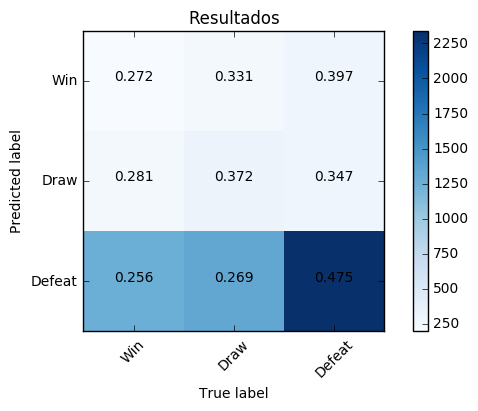

In [34]:
ma_pipe = confusion_matrix(r_pipe, y_test)

plot_confusion_matrix(ma_pipe, classes=["Win", "Draw", "Defeat"], norm=True, title="Resultados")

# Y si utilizamos Pipelines junto con GridSearch?

In [37]:
pca_pipe_2 = PCA()
vt_pipe_2 = VarianceThreshold()
tree_pipe_2 = ExtraTreesClassifier()

pipe_2 = Pipeline([("pca", pca_pipe_2),
                   ("vt", vt_pipe_2),
                   ("tree", tree_pipe_2)])

params = dict(pca__n_components=[2, 3, 5],
              vt__threshold=[(.2*(1-.2))],
              tree__n_estimators=[75, 100, 125],
              tree__criterion=["gini","entropy"],
              tree__random_state=[10,20,30]
            )

gs_pipe = GridSearchCV(pipe_2, params, cv=4, n_jobs=4)
gs_pipe.fit(x_train, y_train)
r_gspipe = gs_pipe.best_estimator_.predict(x_test)

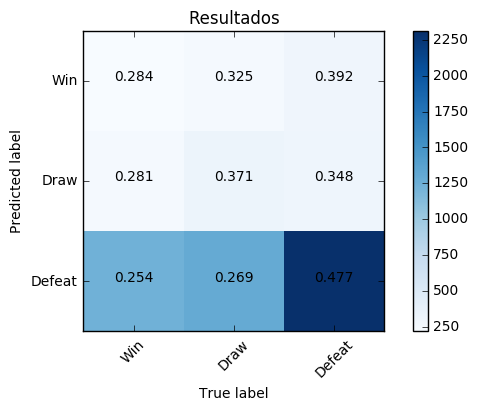

In [38]:
ma_gspipe = confusion_matrix(r_gspipe, y_test)

plot_confusion_matrix(ma_gspipe, classes=["Win", "Draw", "Defeat"], norm=True, title="Resultados")

Si bien el resultado no es bueno, espero los ejemplos de aplicación les sirvan para familiarizarse con las herramientas utilizadas.